In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
# %matplotlib notebook

In [2]:
df_merged = pd.read_pickle('IDRome_DB_reanalyzed_entanglement.pkl')
df_merged

,seq_name,UniProt_ID,N,nu,Rg/nm,Ree/nm,fasta,is_btw_folded,is_nterm,is_cterm,...,last,N_FL,protein_name,gene_name,f+,f-,fcr,ncpr,dir_path,ent_prob
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,1.606731,3.845104,KLGCSPANGNSTVPSLPDNNALFVTAAQTSGLPSSVR,False,False,True,...,181,181,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,0.027027,0.027027,0.054054,0.000000,A0/A0/24/RBG1/145_181,0.001
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,1.447131,3.385064,MAFWLRSLGLHFRPHLGRRMESFLGGVLLILW,False,True,False,...,32,132,T cell receptor alpha variable 6,TRAV6,0.156250,0.031250,0.187500,0.125000,A0/A0/75/B6T7/1_32,0.000
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,2.246105,5.295387,MEDEEKAVEILGNTEAAHPPSPIRCCWLRLRCLAATSIICGCSCLG...,False,True,False,...,67,108,Transmembrane protein 265,TMEM265,0.134328,0.149254,0.283582,-0.014925,A0/A0/87/WTH1/1_67,0.012
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,3.038320,7.131916,MPRMILSNTTAVTPFLTKLWQETVQQGGNMSGLARRSPRSGDGKLE...,False,True,True,...,132,132,Putative potassium voltage-gated channel subfa...,KCNE1B,0.113636,0.098485,0.212121,0.015152,A0/A0/87/WTH5/1_132,0.094
4,A0A087WV53_1_46,A0A087WV53,46,0.567,1.880940,4.603256,MSKAAPAKKPVAVAPAPGCTLDINDPQVQSAAIRIQASYRGHRSRK,False,True,False,...,46,238,SPEG neighbor protein,SPEGNB,0.195652,0.043478,0.239130,0.152174,A0/A0/87/WV53/1_46,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27618,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,3.790272,8.597289,MGDIFKNNGVLQGRLRAVACAPHCFGPRLRCLHHDQGLTELAWGTW...,False,True,True,...,181,181,Putative uncharacterized protein KIF25-AS1,KIF25-AS1,0.121547,0.060773,0.182320,0.060773,Q9/Y6/Z4/1_181,0.138
27619,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,4.586494,10.810353,MGAAGSDGRCCVRSGRAGTGGAGSKWVVMDLWTGGAGSRRAVLGPD...,False,True,True,...,254,254,Putative uncharacterized protein AFDN-DT,AFDN-DT,0.149606,0.035433,0.185039,0.114173,Q9/Y6/Z5/1_254,0.236
27620,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,3.012739,7.121029,MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...,False,True,False,...,109,277,Collectin-10,COLEC10,0.146789,0.128440,0.275229,0.018349,Q9/Y6/Z7/1_109,0.035
27621,W6CW81_1_113,W6CW81,113,0.519,2.943975,6.978634,MESKYKEILLLTSLDNITDEELDRFKCFLPDEFNIATGKLHTLNST...,False,True,True,...,113,113,Pyrin domain-containing protein 5,PYDC5,0.123894,0.150442,0.274336,-0.026549,W6/CW/81/1_113,0.054


In [3]:
idrome_w_ent = df_merged[(df_merged['ent_prob']>0) & (df_merged['N']>=100)].copy()
idrome_wo_ent = df_merged[(df_merged['ent_prob']==0) & (df_merged['N']>=100)].copy()

## Matplotlib setup and data preparation

In [4]:

# Matplotlib settings for publication-quality plots
base_fontsize = 16
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

# Panel (a) Data Preparation
# Filter data for Panel (a): Control for N, exclude short segment
df_merged_N = df_merged[df_merged['N'] >= 100].copy()

# Panel (b) Data Preparation
bin_width = 0.05
bins = pd.interval_range(start=0, end=0.66, freq=bin_width, closed='left')
df_merged_N['nu_bin'] = pd.cut(df_merged_N['nu'], bins=bins)

# Calculate the mean and SEM for each bin
grouped_data = df_merged_N.groupby('nu_bin').agg(
    mean_ent_prob=('ent_prob', 'mean'),
    sem_ent_prob=('ent_prob', 'sem')
).reset_index()

# Format bin labels and calculate bin midpoints
def format_bin_label(interval):
    left = f"{interval.left:.2f}".rstrip('0').rstrip('.')
    right = f"{interval.right:.2f}".rstrip('0').rstrip('.')
    return f"[{left}, {right})"

grouped_data['nu_bin'] = grouped_data['nu_bin'].apply(format_bin_label)
grouped_data['bin_midpoint'] = grouped_data['nu_bin'].apply(
    lambda x: (float(x.split(',')[0][1:]) + float(x.split(',')[1][:-1])) / 2
)

# Panel (c) Data Preparation
x = np.linspace(0, 1, 21)
line_x = np.linspace(0, 1, 100)  # Line data
line_y_1 = 7/6 * line_x - 7/6 * 0.35
line_y_1_masked = np.where(line_y_1 < 0.35, line_y_1, np.nan)
line_y_2 = 6/7 * line_x + 0.35
line_y_2_masked = np.where(line_y_2 < 0.65, line_y_2, np.nan)
line_y_3 = -line_x + 1
line_y_4 = -line_x + 0.35
line_y_5 = -line_x + 0.25

/var/folders/1f/m8_t8g414dz2d33zlncf3gv40000gn/T/ipykernel_51419/3087327720.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_merged_N.groupby('nu_bin').agg(


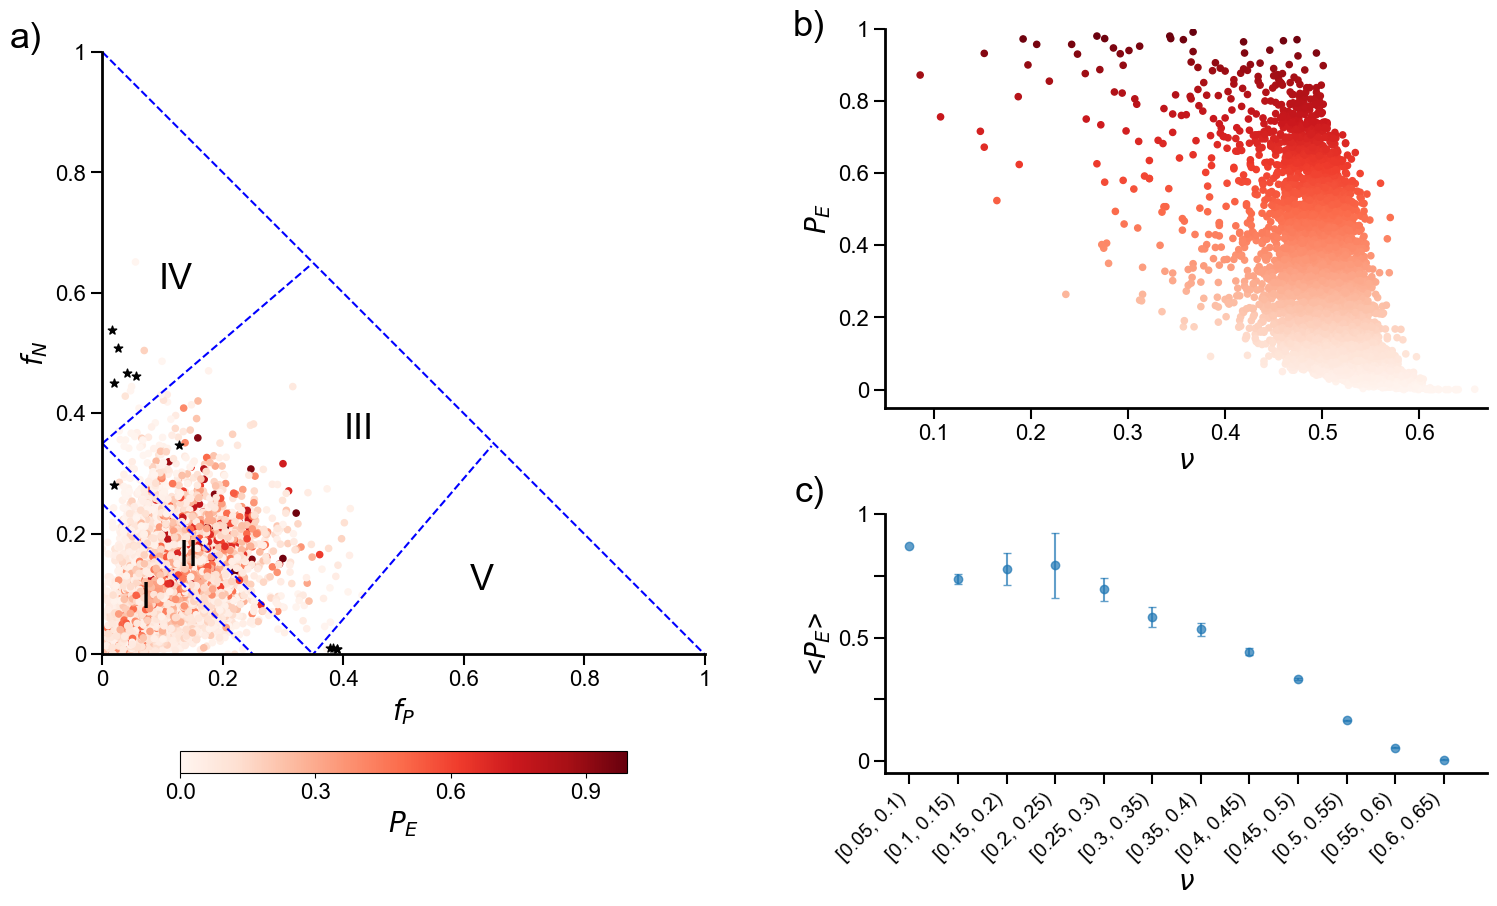

In [9]:
# Adjust the layout ratios to ensure proper centering
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(5, 2, height_ratios=[0.5, 2, 0.4, 1, 1], width_ratios=[1, 1])

# Panels
ax1 = fig.add_subplot(gs[0:4, 0])  # Centered Panel (a) spans full width
ax2 = fig.add_subplot(gs[0:2, 1])  # Panel (b)
ax3 = fig.add_subplot(gs[2:4, 1])  # Panel (c)

# Panel (a): Adjust placement and appearance
sc = ax1.scatter(
    idrome_w_ent['f+'], idrome_w_ent['f-'], 
    s=20, alpha=1.0, c=idrome_w_ent['ent_prob'], cmap='Reds', label='With Entanglement'
)
ax1.scatter(
    idrome_wo_ent['f+'], idrome_wo_ent['f-'], 
    s=40, alpha=1, c='black', marker='*', label='Without Entanglement'
)
ax1.plot(line_x, line_y_1_masked, color='blue', linestyle='--', linewidth=1.5)
ax1.plot(line_x, line_y_2_masked, color='blue', linestyle='--', linewidth=1.5)
ax1.plot(line_x, line_y_3, color='blue', linestyle='--', linewidth=1.5)
ax1.plot(line_x, line_y_4, color='blue', linestyle='--', linewidth=1.5)
ax1.plot(line_x, line_y_5, color='blue', linestyle='--', linewidth=1.5)
ax1.set_xlabel('$f_{P}$', fontsize=base_fontsize+4)
ax1.set_ylabel('$f_{N}$', fontsize=base_fontsize+4)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# yticks
general_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]  # Tick positions
general_ticklabels = ['0', '0.2', '0.4', '0.6', '0.8', '1']  # Only show labels for 0, 0.5, and 1
ax1.set_yticks(general_ticks)
ax1.set_yticklabels(general_ticklabels)
ax1.set_xticks(general_ticks)
ax1.set_xticklabels(general_ticklabels)
ax1.tick_params(labelsize=base_fontsize, length=8, width=1.5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.set_aspect('equal', adjustable='box')
# ax1.legend(fontsize=base_fontsize + 2, loc='upper right', frameon=False)

ax1.text(0.08, 0.12, 'I', transform=ax1.transAxes, fontsize=base_fontsize+10, c='black', fontweight='regular', va='top', ha='right')
ax1.text(0.16, 0.19, 'II', transform=ax1.transAxes, fontsize=base_fontsize+10, c='black', fontweight='regular', va='top', ha='right')
ax1.text(0.45, 0.4, 'III', transform=ax1.transAxes, fontsize=base_fontsize+10, c='black', fontweight='regular', va='top', ha='right')
ax1.text(0.15, 0.65, 'IV', transform=ax1.transAxes, fontsize=base_fontsize+10, c='black', fontweight='regular', va='top', ha='right')
ax1.text(0.65, 0.15, 'V', transform=ax1.transAxes, fontsize=base_fontsize+10, c='black', fontweight='regular', va='top', ha='right')

# Add label for Panel (a)
ax1.text(-0.1, 1.05, 'a)', transform=ax1.transAxes, fontsize=base_fontsize+10, fontweight='regular', va='top', ha='right')



# Add colorbar to Panel (a)
cbar = fig.colorbar(sc, ax=ax1, orientation='horizontal', fraction=0.03, pad=0.13)
# cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', fraction=0.03, pad=-0.35)
cbar.set_label('$P_{E}$', fontsize=base_fontsize+4)
cbar.ax.tick_params(labelsize=base_fontsize)
cbar.set_ticks(np.arange(0, 1, 0.3))  # Custom ticks including 1

# Panel (b): Scatter plot
ax2.scatter(df_merged_N['nu'], df_merged_N['ent_prob'], s=20, alpha=1.0, c=df_merged_N.ent_prob, cmap='Reds', )
ax2.set_xlabel('$\\nu$', fontsize=base_fontsize+4)
ax2.set_ylabel('$P_{E}$', fontsize=base_fontsize+4)
ax2.set_xlim(0.05, 0.67)
ax2.set_ylim(-0.05, 1)
# xticks
ax2.set_xticks(np.arange(0.1, 0.7, 0.1))
ax2.tick_params(labelsize=base_fontsize, length=8, width=1.5)
# yticks
general_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]  # Tick positions
general_ticklabels = ['0', '0.2', '0.4', '0.6', '0.8', '1']  # Only show labels for 0, 0.5, and 1
ax2.set_yticks(general_ticks)
ax2.set_yticklabels(general_ticklabels)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

# Add label for Panel (b)
ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, fontsize=base_fontsize+10, fontweight='regular', va='top', ha='right')


# Panel (c): Mean and SEM plot
ax3.errorbar(grouped_data['bin_midpoint'], grouped_data['mean_ent_prob'], 
             yerr=grouped_data['sem_ent_prob'], fmt='o', capsize=3, alpha=0.7)
ax3.set_xlabel('$\\nu$', fontsize=base_fontsize+4)
ax3.set_ylabel('<$P_{E}$>', fontsize=base_fontsize+4)
ax3.set_xlim(0.05, 0.67)
ax3.set_ylim(-0.05, 1)
# set xticks
ax3.set_xticks(grouped_data['bin_midpoint'][1:])
ax3.set_xticklabels(grouped_data['nu_bin'][1:], rotation=45, ha='right')
# ax3.set_xticklabels(grouped_data['nu_bin'][1:], rotation=45, ha='right')
# Custom y-ticks and labels
yticks = [0, 0.25, 0.5, 0.75, 1]  # Tick positions
yticklabels = ['0', '', '0.5', '', '1']  # Only show labels for 0, 0.5, and 1
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticklabels)

ax3.tick_params(axis='y', labelsize=base_fontsize, length=8, width=1.5)
ax3.tick_params(axis='x', labelsize=base_fontsize - 2, length=8, width=1.5)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_linewidth(2)
ax3.spines['bottom'].set_linewidth(2)
# ax3.set_yscale('log')
# Add label for Panel (c)
ax3.text(-0.1, 1.15, 'c)', transform=ax3.transAxes, fontsize=base_fontsize+10, fontweight='regular', va='top', ha='right')

# Adjust layout and spacing
plt.tight_layout()
fig.subplots_adjust(top=0.9, bottom=0.1, hspace=1, wspace=0.3)  # Adjust hspace to center Panel (a)

# Save and display the figure
plt.savefig(f'IDRome.png', dpi=600, bbox_inches='tight')
plt.show()
